# HW2
In this homework, stroke needs to be predicted from given data.

First, libraries and data need to be imported.

In [99]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
from sklearn.metrics import roc_auc_score, roc_curve # roc_auc scoring
from sklearn.model_selection import KFold # splitting data
from sklearn.linear_model import LogisticRegression, SGDClassifier  # linear models
from sklearn.model_selection import GridSearchCV, train_test_split # importing splitting train data and optimal hyperparameter search
from sklearn.ensemble import RandomForestClassifier # Random forest
from sklearn.tree import DecisionTreeClassifier # Decidiom tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from category_encoders.woe import WOEEncoder

In [2]:
#reading files and making dataframes out of them
sample = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

### Part 1
First, let's explore the data.

In [3]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


Let's see if there is any correlation in the data.

In [4]:
cor = train.corr()
cor.style.background_gradient(cmap='coolwarm')

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
id,1,0.0134422,0.00982343,0.00682854,0.0221249,0.0176893,0.00736639
age,0.0134422,1,0.274369,0.25277,0.234806,0.35584,0.152684
hypertension,0.00982343,0.274369,1,0.121906,0.161272,0.161511,0.0734252
heart_disease,0.00682854,0.25277,0.121906,1,0.149709,0.0609177,0.101548
avg_glucose_level,0.0221249,0.234806,0.161272,0.149709,1,0.188645,0.0874264
bmi,0.0176893,0.35584,0.161511,0.0609177,0.188645,1,0.020317
stroke,0.00736639,0.152684,0.0734252,0.101548,0.0874264,0.020317,1


It appears that there is no strong correlation. Now, let's visualize what we have.

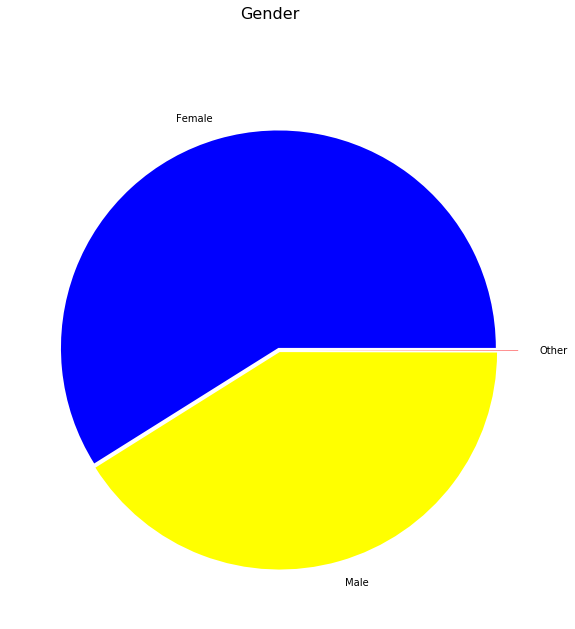

In [5]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Gender', fontsize=16)
plt.pie(train.gender.value_counts(), labels=['Female', 'Male', 'Other'], explode=(0.01, 0.01, 0.1), colors=['Blue', 'Yellow', 'Red']) 
plt.show()

Here we can see that there are three genders represented, althoug "Other" is almost absent from the dataset. The "Male" part of the dataset is represented a bit worse than "Female". This is a bit innacurate, as male part of the population in the world is a bit bigger, than female.

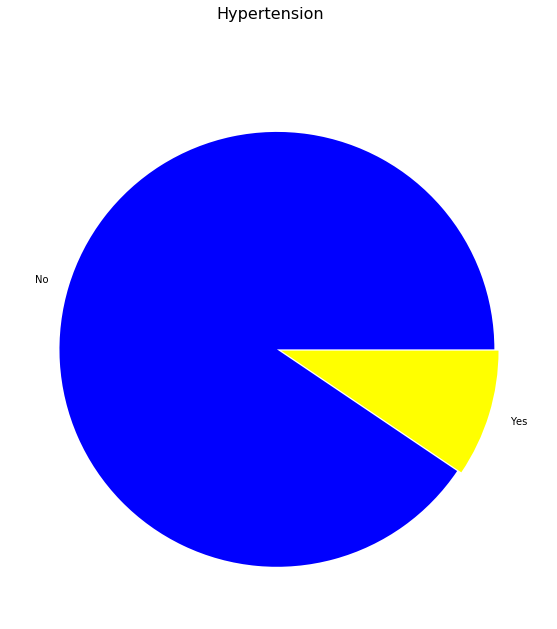

In [6]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Hypertension', fontsize=16)
plt.pie(train.hypertension.value_counts(), labels=['No', 'Yes'], explode=(0.01, 0.01), colors=['Blue', 'Yellow']) 
plt.show()

In this diagram it is seen that about 10% of the dataset samples have hypertention. Generally, in the world, about 16-30% are affected by it.

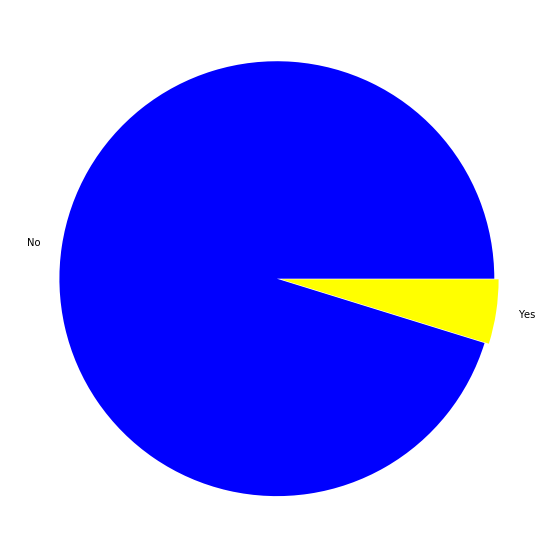

In [7]:
plt.figure(figsize=(10, 10))
fig.suptitle('Heart disease', fontsize=16)
plt.pie(train.heart_disease.value_counts(), labels=['No', 'Yes'], explode=(0.01, 0.01), colors=['Blue', 'Yellow']) 
plt.show()

From this diagram, it can be seen that about 5% of the samples represented in the dataset have some kind of heart disease

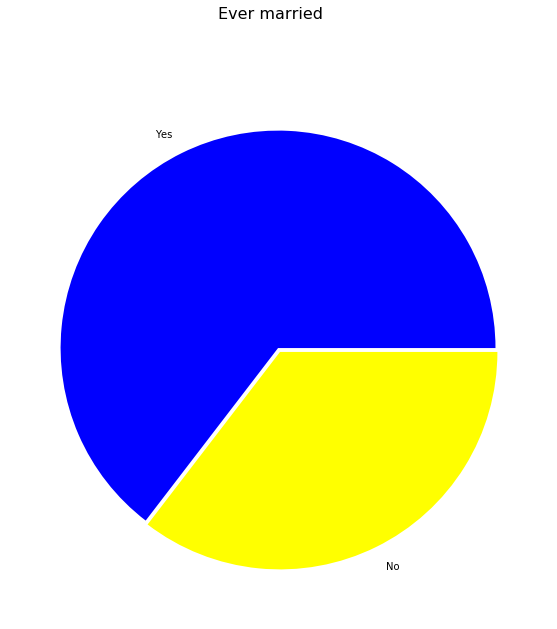

In [8]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Ever married', fontsize=16)
plt.pie(train.ever_married.value_counts(), labels=['Yes', 'No'], explode=(0.01, 0.01), colors=['Blue', 'Yellow']) 
plt.show()

This diagram shows that about 2/3 of samples have ever been married.

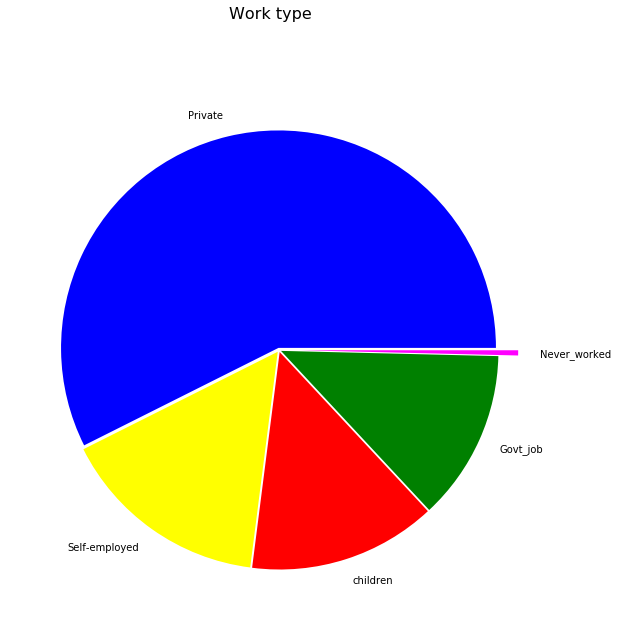

In [9]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Work type', fontsize=16)
plt.pie(train.work_type.value_counts(), labels=['Private', 'Self-employed', 'children', 'Govt_job', 
                                                'Never_worked'], explode=(0.01, 0.01, 0.01, 0.01, 0.1), 
                                         colors=['Blue', 'Yellow', 'Red', 'Green', 'Fuchsia']) 
plt.show()

This diagram shows the different work types samples have.

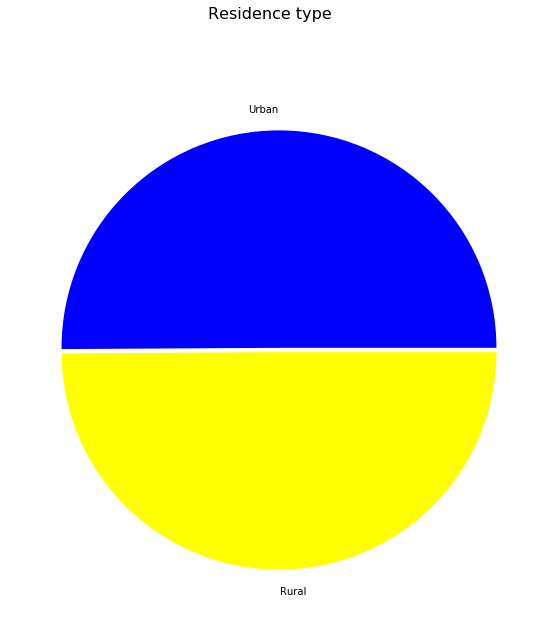

In [10]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Residence type', fontsize=16)
plt.pie(train.Residence_type.value_counts(), labels=['Urban', 'Rural'], explode=(0.01, 0.01), colors=['Blue', 'Yellow']) 
plt.show()

In this diagram it can be seen that about half of samples live in rural areas. As statistics show, a bit more people live in urban areas than in rural.

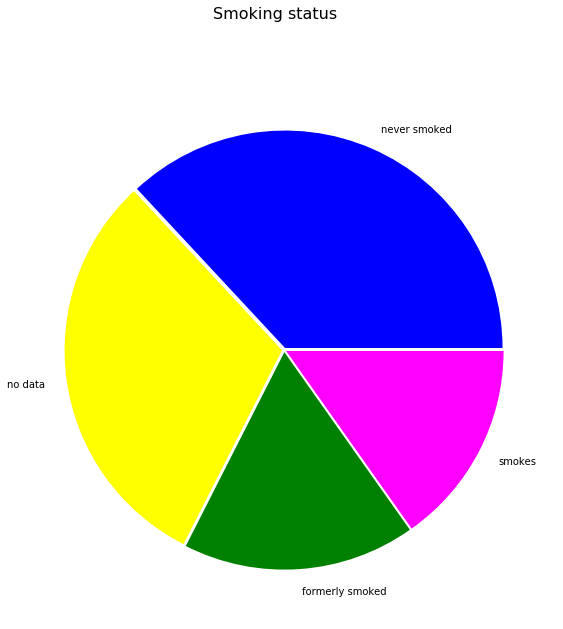

In [11]:
train['smoking_status'] = train['smoking_status'].fillna('no data') # for the timebeing, replacing nan with 'no data'
test['smoking_status'] = test['smoking_status'].fillna('no data')
labels = list(['never smoked', 'no data', 'formerly smoked', 'smokes'])
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Smoking status', fontsize=16)
plt.pie(train.smoking_status.value_counts(), labels=labels,
        explode=(0.01, 0.01, 0.01, 0.01), colors=['Blue', 'Yellow', 'Green', 'Fuchsia']) 
plt.show()

This diagram shows sample smoking tendencies, but, as it can be seen, a large part of dataset does not have information about smoking status.

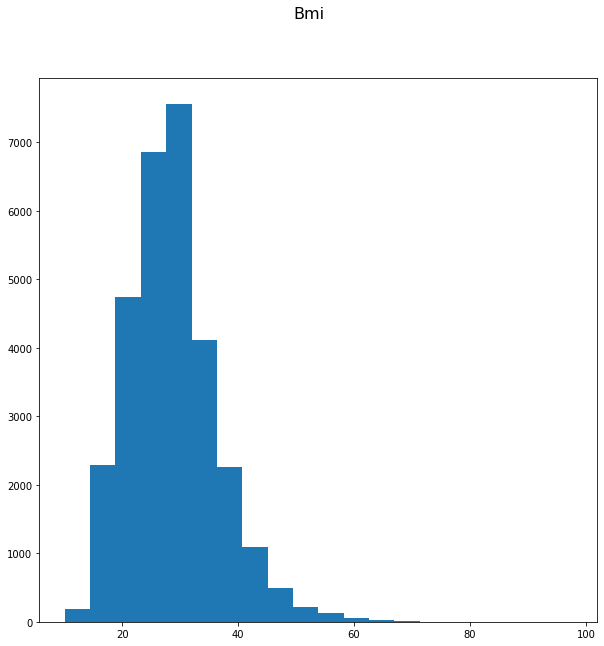

In [12]:
mean_bmi = train['bmi'].mean()
train['bmi'] = train['bmi'].fillna(mean_bmi) # replacing nan with mean value
test['bmi'] = test['bmi'].fillna(mean_bmi)
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Bmi', fontsize=16)
plt.hist(train.bmi.values,bins=20) 
plt.show()

The healthy BMI values lie between 18.5 and 25. In this dataset, a lot of people are overweight.

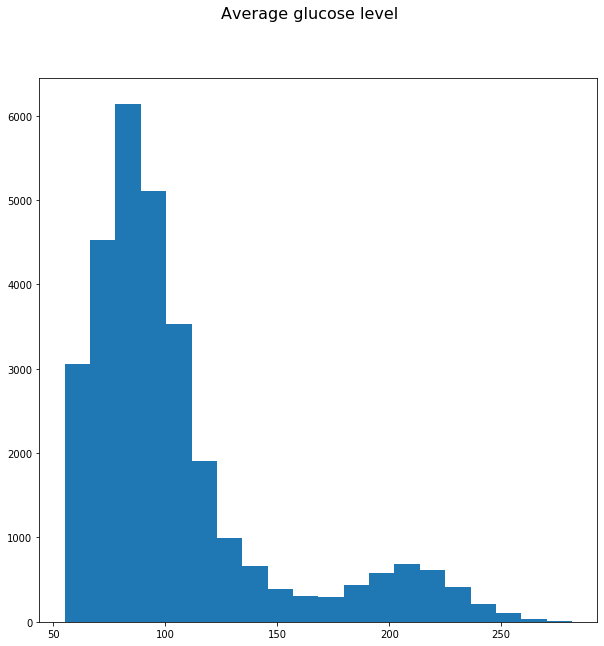

In [13]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Average glucose level', fontsize=16)
plt.hist(train.avg_glucose_level.values,bins=20) 
plt.show()

Although it is not indicated, average glucose level is probably measured in mg/dL. If so, the healthy values lie between 72 and 99.If more, a person has type 1 or 2 diabetes.

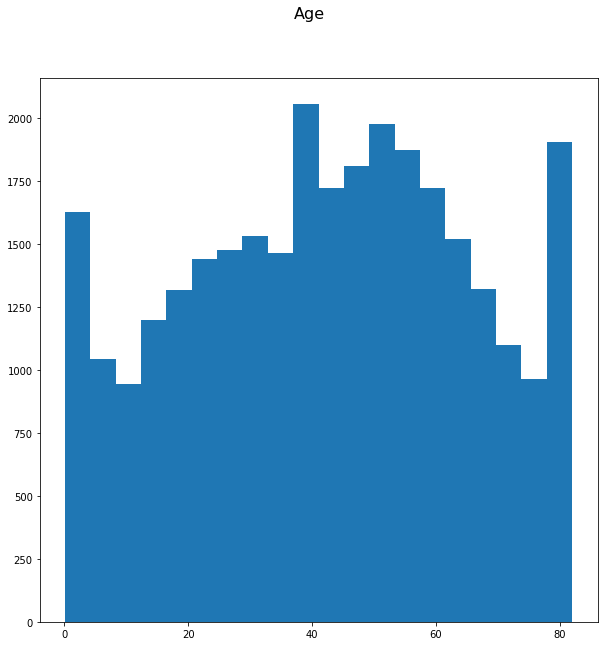

In [14]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Age', fontsize=16)
plt.hist(train.age.values,bins=20) 
plt.show()

From this histogram, it can be seen that most samples are adults about 40 - 60 years old

### Part 2
Next, we need to work on the data. 

In [15]:
y = train['stroke']
train = train.drop(['id', 'stroke'], axis=1)
test = test.drop(['id'], axis=1)

Let's use WOE for every categorical data

In [20]:
woe = WOEEncoder()
woe.fit(train['gender'], y)
train['gender'] = woe.transform(train['gender'])
test['gender'] = woe.transform(test['gender'])

In [21]:
woe = WOEEncoder()
woe.fit(train['smoking_status'], y)
train['smoking_status'] = woe.transform(train['smoking_status'])
test['smoking_status'] = woe.transform(test['smoking_status'])

In [22]:
woe = WOEEncoder()
woe.fit(train['Residence_type'], y)
train['Residence_type'] = woe.transform(train['Residence_type'])
test['Residence_type'] = woe.transform(test['Residence_type'])

In [23]:
woe = WOEEncoder()
woe.fit(train['work_type'], y)
train['work_type'] = woe.transform(train['work_type'])
test['work_type'] = woe.transform(test['work_type'])

In [24]:
woe = WOEEncoder()
woe.fit(train['ever_married'], y)
train['ever_married'] = woe.transform(train['ever_married'])
test['ever_married'] = woe.transform(test['ever_married'])

For glucose level and bmi, let's perform MinMax normalization.

In [32]:
scaler = MinMaxScaler()
scaler.fit(train['avg_glucose_level'].values.reshape(-1, 1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [33]:
train['avg_glucose_level'] = scaler.transform(train['avg_glucose_level'].values.reshape(-1, 1))
test['avg_glucose_level'] = scaler.transform(test['avg_glucose_level'].values.reshape(-1, 1))

In [35]:
scaler = MinMaxScaler()
scaler.fit(train['bmi'].values.reshape(-1, 1))
train['bmi'] = scaler.transform(train['bmi'].values.reshape(-1, 1))
test['bmi'] = scaler.transform(test['bmi'].values.reshape(-1, 1))

For age, let's use normalization to N(0, 1)

In [37]:
scaler = StandardScaler()
scaler.fit(train['age'].values.reshape(-1, 1))
train['age'] = scaler.transform(train['age'].values.reshape(-1, 1))
test['age'] = scaler.transform(test['age'].values.reshape(-1, 1))

### Part 3
Here, the models will be trained and submissions will be made.

In [44]:
def my_cross_validation(clf, X, y ,cv=5): # crossvalidation
    X = np.array(X.copy())
    y = np.array(y.copy())
    kf = KFold(n_splits=cv)
    kf.get_n_splits(X)
    scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        prediction_on_this_fold = clf.predict_proba(X_test)[:,1]
        score = roc_auc_score(y_score=prediction_on_this_fold, y_true=y_test)
        scores.append(score)
    return scores

First, let's split data so that we always have a part to test on locally.

In [122]:
X_train, X_test, Y_train, Y_test = train_test_split(train, y, test_size=0.2)

#### Logistic regression
Now, let's figure out best cross-validation value for best model.

In [123]:
for i in range(3, 21):
    model=LogisticRegression()
    print(i, np.mean(my_cross_validation(model, X_train, Y_train, cv=i)))

3 0.8429641320985533
4 0.8445470544853066
5 0.8447847017586924
6 0.8453038675172114
7 0.8457242599913846
8 0.8446570745714891
9 0.8463729962255319
10 0.84526049068771
11 0.8474424744127826
12 0.8444563126115487
13 0.8463122380188447
14 0.8451049140502743
15 0.8463580612665178
16 0.8465452940022866
17 0.8460578299236651
18 0.8441790715126845
19 0.8459684853449709
20 0.8458178712238947


Looks like optimal split for logistic regression would be 11. <br>
Next, let's perform feature selection using crossvalidation.

In [124]:
features = X_train.columns
model = LogisticRegression()
features_scores = {}
for f in features:
    scores = my_cross_validation(model, X_train[[f]] , Y_train, 11)
    print(f,  np.mean(scores))
    features_scores[f] = np.mean(scores)

gender 0.5192813038601239
age 0.8350306386754166
hypertension 0.5797323353409675
heart_disease 0.5870170559684316
ever_married 0.6209178076025295
work_type 0.6175758743578054
Residence_type 0.46455321249163234
avg_glucose_level 0.6251474523922045
bmi 0.5633505623113855
smoking_status 0.58806182291569


For logistic regression, we see that strong prediction power belongs to age, ever_married, work_type, avg_glucose_level (let's choose every feature for which ROC-AUC score is bigger than 0.6).

In [125]:
features_log_reg = ['age', 'ever_married', 'work_type', 'avg_glucose_level']
X_train, X_test = X_train[features_log_reg], X_test[features_log_reg]

In [126]:
params_log_reg = {
    'penalty' : [ 'l2', 'l1', 'elasticnet'],
    "tol" : [1e-5, 1e-3, 1e-4],
    'solver' :['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
    "max_iter" : [ 50, 100, 500, 1000, 1500, 2000, 2500]
}

In [127]:
model = LogisticRegression()
grid = GridSearchCV(model, params_log_reg, n_jobs=15, scoring="roc_auc", cv=11, verbose=5) 
#searching through all possible hypreparemeter combinations with 10-fold cross-validation and 
#choosing the combination with best auc score

In [128]:
grid.fit(X_train, Y_train)

Fitting 11 folds for each of 315 candidates, totalling 3465 fits


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=15)]: Done 132 tasks      | elapsed:    3.9s
[Parallel(n_jobs=15)]: Done 297 tasks      | elapsed:    5.2s
[Parallel(n_jobs=15)]: Done 945 tasks      | elapsed:    9.7s
[Parallel(n_jobs=15)]: Done 1722 tasks      | elapsed:   16.9s
[Parallel(n_jobs=15)]: Done 2271 tasks      | elapsed:   21.9s
[Parallel(n_jobs=15)]: Done 2928 tasks      | elapsed:   26.9s
[Parallel(n_jobs=15)]: Done 3465 out of 3465 | elapsed:   31.7s finished


GridSearchCV(cv=11, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=15,
             param_grid={'max_iter': [50, 100, 500, 1000, 1500, 2000, 2500],
                         'penalty': ['l2', 'l1', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga'],
                         'tol': [1e-05, 0.001, 0.0001]},
             pre_dispatch='2*n_j

Next, let's fix all parameters except number of iterations 

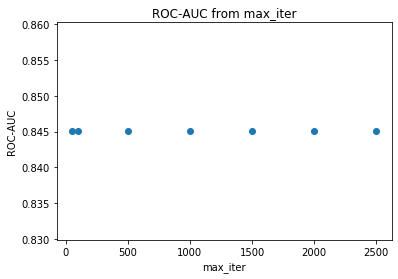

In [129]:
max_iter = [50, 100, 500, 1000, 1500, 2000, 2500]
solver_log = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
tol_log = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
scores_from_param = []
for i in max_iter:
    model = LogisticRegression(max_iter=i, solver='lbfgs', tol=1e-4)
    scores_from_param.append(np.mean(my_cross_validation(model, X_train, Y_train, 11)))
plt.scatter(max_iter, scores_from_param)
plt.xlabel('max_iter')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC from max_iter')
plt.show()

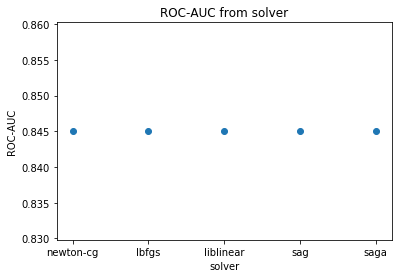

In [130]:
scores_from_param = []
for i in solver_log:
    model = LogisticRegression(solver=i, tol=1e-4, max_iter=100)
    scores_from_param.append(np.mean(my_cross_validation(model, X_train, Y_train, 11)))
plt.scatter(solver_log, scores_from_param)
plt.xlabel('solver')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC from solver')
plt.show()

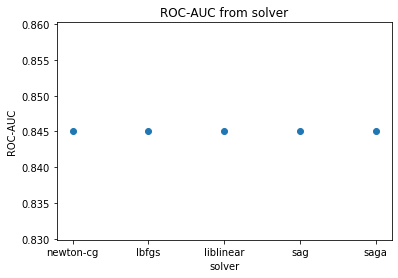

In [131]:
scores_from_param = []
for i in tol_log:
    model = LogisticRegression(solver='lbfgs', tol=i, max_iter=100)
    scores_from_param.append(np.mean(my_cross_validation(model, X_train, Y_train, 11)))
plt.scatter(solver_log, scores_from_param)
plt.xlabel('solver')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC from solver')
plt.show()

It is clearly seen that there is no strong influence from parameters to the model. <br>
Finally, let's train best estimator on X_train and than check it on X_test

In [132]:
model = grid.best_estimator_
model.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.001, verbose=0,
                   warm_start=False)

Now, let's predict on the part that we left for the test and plot roc-curve.

In [133]:
scores = model.predict_proba(X_test)

In [108]:
fpr, tpr, thresholds = roc_curve(Y_test, scores[:,1])

<function matplotlib.pyplot.show(*args, **kw)>

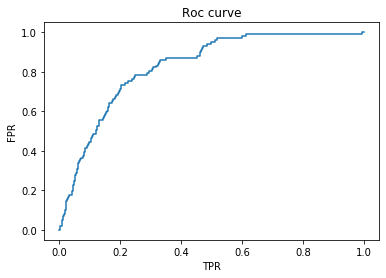

In [134]:
plt.plot(fpr, tpr)
plt.xlabel('TPR')
plt.ylabel('FPR')
plt.title('Roc curve')
plt.show

Local roc-auc score

In [135]:
roc_auc_score(Y_test, scores[:, 1])

0.8491573290199711

In [136]:
res = model.predict_proba(test[features_log_reg])
sample['stroke'] = res[:, 1]
sample.to_csv('submit_log_reg.csv', index = None )

Leaderboard score - 0.84726

#### Decision tree
Now, repeat all the same steps for decision tree

In [162]:
X_train, X_test, Y_train, Y_test = train_test_split(train, y, test_size=0.2)

In [163]:
for i in range(3, 21):
    model=DecisionTreeClassifier()
    print(i, np.mean(my_cross_validation(model, X_train, Y_train, cv=i)))

3 0.5214310511440909
4 0.5269828962244512
5 0.5360167572355036
6 0.525545909926833
7 0.519304935948124
8 0.5265844483087523
9 0.5382408438392144
10 0.5380944209346146
11 0.539242944303608
12 0.5283690057452894
13 0.5195124623394027
14 0.5298967430707975
15 0.530139567446366
16 0.5328230412358824
17 0.528346586736119
18 0.5410866985683962
19 0.5422849452271454
20 0.5295756335202083


Optimal split - 12

In [164]:
features = X_train.columns
model = DecisionTreeClassifier()
features_scores = {}
for f in features:
    scores = my_cross_validation(model, X_train[[f]] , Y_train, 12)
    print(f,  np.mean(scores))
    features_scores[f] = np.mean(scores)

gender 0.5242386713108597
age 0.8284608779927605
hypertension 0.5844710042882507
heart_disease 0.5807653936546807
ever_married 0.6332965500631439
work_type 0.624772887037436
Residence_type 0.5066619033107643
avg_glucose_level 0.49780069833551965
bmi 0.5685610660567102
smoking_status 0.591227884387428


For decision tree, we see that strong prediction power belongs to age, ever_married, work_type, smoking_status and hypertension (let's choose every feature for which ROC-AUC score is bigger than 0.59).

In [165]:
features_dec_tree = ['age', 'ever_married', 'work_type', 'smoking_status', 'hypertension']
X_train, X_test = X_train[features_dec_tree], X_test[features_dec_tree]

In [166]:
params_dec_tree = {
    'criterion' : ['gini', 'entropy'],
    'splitter' : ['best', 'random'],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': ['auto', 'sqrt', 'log'], 
    'max_leaf_nodes': [None, 6, 10, 14, 20]
}
model = DecisionTreeClassifier()
grid = GridSearchCV(model, params_dec_tree, n_jobs=15, scoring="roc_auc", cv=12, verbose=5) 
#searching through all possible hypreparemeter combinations with 10-fold cross-validation and 
#choosing the combination with best auc score

In [167]:
grid.fit(X_train, Y_train)

Fitting 12 folds for each of 1500 candidates, totalling 18000 fits


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  42 tasks      | elapsed:    2.2s
[Parallel(n_jobs=15)]: Done 132 tasks      | elapsed:    2.8s
[Parallel(n_jobs=15)]: Done 366 tasks      | elapsed:    3.9s
[Parallel(n_jobs=15)]: Done 690 tasks      | elapsed:    5.3s
[Parallel(n_jobs=15)]: Done 1086 tasks      | elapsed:    7.0s
[Parallel(n_jobs=15)]: Done 1554 tasks      | elapsed:    9.1s
[Parallel(n_jobs=15)]: Done 2094 tasks      | elapsed:   11.6s
[Parallel(n_jobs=15)]: Done 2706 tasks      | elapsed:   14.8s
[Parallel(n_jobs=15)]: Done 3390 tasks      | elapsed:   18.5s
[Parallel(n_jobs=15)]: Done 4146 tasks      | elapsed:   22.2s
[Parallel(n_jobs=15)]: Done 4974 tasks      | elapsed:   26.1s
[Parallel(n_jobs=15)]: Done 5874 tasks      | elapsed:   30.4s
[Parallel(n_jobs=15)]: Done 7452 tasks      | elapsed:   36.9s
[Parallel(n_jobs=15)]: Done 9540 tasks      | elapsed:   45.1s
[Parallel(n_jobs=15)]: Done 11772 tasks      

GridSearchCV(cv=12, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=15,
             param_grid={'criterion': ['gini', 'entropy'],
                    

In [168]:
min_split = [2, 4, 6, 8, 10]
min_leaf = [1, 2, 3, 4, 5]
max_nodes = [None, 6, 10, 14, 20]

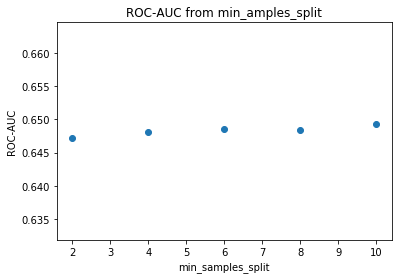

In [169]:
scores_from_param = []
for i in min_split:
    model = DecisionTreeClassifier(min_samples_split=i, min_samples_leaf=1, max_leaf_nodes=None)
    scores_from_param.append(np.mean(my_cross_validation(model, X_train, Y_train, 12)))
plt.scatter(min_split, scores_from_param)
plt.xlabel('min_samples_split')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC from min_amples_split')
plt.show()

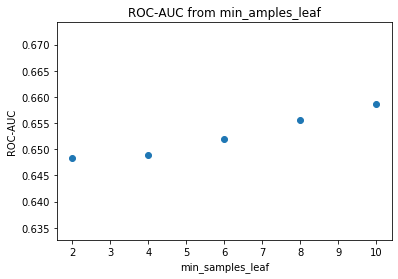

In [170]:
scores_from_param = []
for i in min_leaf:
    model = DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=i, max_leaf_nodes=None)
    scores_from_param.append(np.mean(my_cross_validation(model, X_train, Y_train, 12)))
plt.scatter(min_split, scores_from_param)
plt.xlabel('min_samples_leaf')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC from min_amples_leaf')
plt.show()

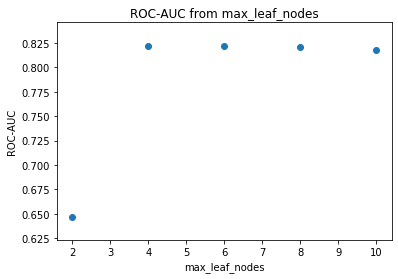

In [171]:
scores_from_param = []
for i in max_nodes:
    model = DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=1, max_leaf_nodes=i)
    scores_from_param.append(np.mean(my_cross_validation(model, X_train, Y_train, 12)))
plt.scatter(min_split, scores_from_param)
plt.xlabel('max_leaf_nodes')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC from max_leaf_nodes')
plt.show()

In [212]:
Here, parameter values clearly influence performance

SyntaxError: invalid syntax (<ipython-input-212-f48c5c769959>, line 1)

In [172]:
model = grid.best_estimator_
model.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=14,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

<function matplotlib.pyplot.show(*args, **kw)>

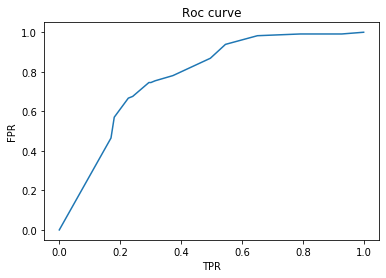

In [173]:
scores = model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, scores[:,1])
plt.plot(fpr, tpr)
plt.xlabel('TPR')
plt.ylabel('FPR')
plt.title('Roc curve')
plt.show

In [174]:
roc_auc_score(Y_test, scores[:, 1])

0.7740695376967984

In [175]:
res = model.predict_proba(test[features_dec_tree])
sample['stroke'] = res[:, 1]
sample.to_csv('submit_dec_tree.csv', index = None )

Leaderboard score - 0.81591

#### Random forest

In [189]:
X_train, X_test, Y_train, Y_test = train_test_split(train, y, test_size=0.2)

In [190]:
for i in range(3, 21):
    model = RandomForestClassifier()
    print(i, np.mean(my_cross_validation(model, X_train, Y_train, cv=i)))

3 0.7812247043189865
4 0.7852248319386097
5 0.7836078423018208
6 0.7727719378500898
7 0.7924257519667831
8 0.7846383660290797
9 0.7764859307240872
10 0.7778189495446896
11 0.7777414405937378
12 0.7768064238495409
13 0.779710886098951
14 0.7767206077544626
15 0.7782764994822867
16 0.7730913713952654
17 0.7838591585125462
18 0.7720038902034998
19 0.7761187051991231
20 0.7788976427330925


Optimal split - 4

In [191]:
features = X_train.columns
model = RandomForestClassifier()
features_scores = {}
for f in features:
    scores = my_cross_validation(model, X_train[[f]] , Y_train, 4)
    print(f,  np.mean(scores))
    features_scores[f] = np.mean(scores)

gender 0.5099614949266406
age 0.8246154827573746
hypertension 0.575589875156748
heart_disease 0.5861520012694834
ever_married 0.6312332652903585
work_type 0.5938705685728407
Residence_type 0.4798933241968423
avg_glucose_level 0.4976299571685041
bmi 0.5602935125376151
smoking_status 0.591501304877883


For random forest, we see that strong prediction power belongs to age, ever_married, work_type, heart_disease, bmi (let's choose every feature for which ROC-AUC score is bigger than 0.58).

In [192]:
features_rand_for = ['age', 'ever_married', 'work_type', 'heart_disease', 'smoking_status']
X_train, X_test = X_train[features_rand_for], X_test[features_rand_for]

In [196]:
params_rand_for = {
    'criterion' : ['gini', 'entropy'],
    'n_estimators': [10, 50, 100, 150, 200],
    'max_depth' : [None, 5, 7, 9, 11],
    'max_features': ['auto', 'sqrt', 'log'], 
}
model = RandomForestClassifier()
grid = GridSearchCV(model, params_rand_for, n_jobs=15, scoring="roc_auc", cv=4, verbose=5) 
#searching through all possible hypreparemeter combinations with 10-fold cross-validation and 
#choosing the combination with best auc score

In [197]:
grid.fit(X_train, Y_train)

Fitting 4 folds for each of 150 candidates, totalling 600 fits


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=15)]: Done 132 tasks      | elapsed:   11.8s
[Parallel(n_jobs=15)]: Done 258 tasks      | elapsed:   22.8s
[Parallel(n_jobs=15)]: Done 420 tasks      | elapsed:   36.1s
[Parallel(n_jobs=15)]: Done 600 out of 600 | elapsed:   54.3s finished


GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [200]:
min_split = [2, 4, 6, 8, 10]
n_estimators = [10, 50, 100, 150, 200]
max_depth = [None, 5, 7, 9, 11]

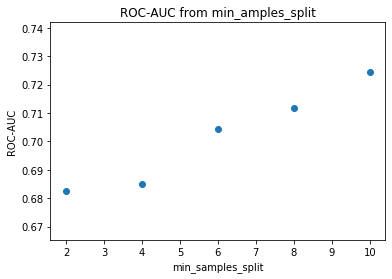

In [201]:
scores_from_param = []
for i in min_split:
    model = RandomForestClassifier(min_samples_split=i, n_estimators=100, max_depth=None)
    scores_from_param.append(np.mean(my_cross_validation(model, X_train, Y_train, 4)))
plt.scatter(min_split, scores_from_param)
plt.xlabel('min_samples_split')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC from min_amples_split')
plt.show()

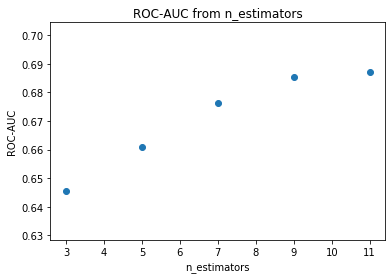

In [203]:
scores_from_param = []
for i in n_estimators:
    model = RandomForestClassifier(min_samples_split=2, n_estimators=i, max_depth=None)
    scores_from_param.append(np.mean(my_cross_validation(model, X_train, Y_train, 4)))
plt.scatter(max_depth, scores_from_param)
plt.xlabel('n_estimators')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC from n_estimators')
plt.show()

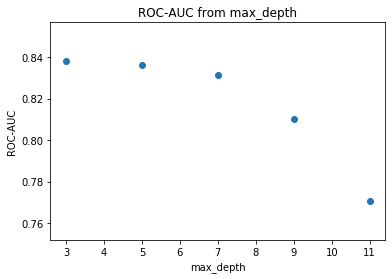

In [211]:
scores_from_param = []
for i in max_depth:
    model = RandomForestClassifier(min_samples_split=2, n_estimators=100, max_depth=i)
    scores_from_param.append(np.mean(my_cross_validation(model, X_train, Y_train, 4)))
plt.scatter(max_depth, scores_from_param)
plt.xlabel('max_depth')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC from max_depth')
plt.show()

Here, parameter values clearly influence performance

In [205]:
model = grid.best_estimator_
model.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

<function matplotlib.pyplot.show(*args, **kw)>

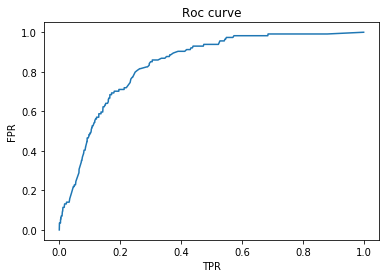

In [206]:
scores = model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, scores[:,1])
plt.plot(fpr, tpr)
plt.xlabel('TPR')
plt.ylabel('FPR')
plt.title('Roc curve')
plt.show

In [207]:
roc_auc_score(Y_test, scores[:, 1])

0.8378511677529137

In [210]:
res = model.predict_proba(test[features_dec_tree])
sample['stroke'] = res[:, 1]
sample.to_csv('submit_rand_for.csv', index = None )

Leaderboard score 0.84977